# Imports, constants and functions

In [1]:
import os
import re
import nrrd
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import pingouin as pg
import radiomics as pr
import SimpleITK as sitk
import matplotlib.pyplot as plt
from radiomics import featureextractor
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.ndimage import binary_dilation, binary_erosion
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Configura pandas para mostrar todo el DataFrame
pd.set_option('display.max_rows', None)      # Todas las filas
pd.set_option('display.max_columns', None)   # Todas las columnas
pd.set_option('display.width', None)         # Todo el ancho posible
pd.set_option('display.max_colwidth', None)  # Ancho completo del contenido de la columna

In [ ]:
# Constantes
INPUT_PATH = '/Users/veramegias/Documents/Universidad/Cuarto/TFG/Segmentaciones'
IMAGES_PATH = 'images'
OUTPUT_PATH = 'outputs'
DATA_PATH = 'data'
REEXECUTE = False
MAX_NUM = 9

columns_file_text = f'{OUTPUT_PATH}/columnas_df_features.txt'

In [4]:
def preprocess_features(df, label_column, threshold_corr=0.95, threshold_var=0.01):
    """
    Preprocesa un DataFrame eliminando variables constantes, colineales y normalizando los datos.

    Pasos:
        1. Separa las variables independientes (X) y la variable objetivo (y).
        2. Elimina variables con baja varianza (prácticamente constantes).
        3. Elimina variables con alta correlación para reducir colinealidad.
        4. Normaliza las características con StandardScaler.

    Args:
        df (pd.DataFrame): DataFrame con las características radiómicas y la columna de la variable objetivo.
        label_column (str): Nombre de la columna que contiene la variable objetivo.
        threshold_corr (float): Umbral de correlación para eliminar variables (default 0.95).
        threshold_var (float): Umbral de varianza mínima para eliminar variables constantes (default 0.01).
    
    Returns:
        pd.DataFrame: DataFrame con las características preprocesadas, filtradas y normalizadas.
        pd.Series: Variable objetivo (y).
        list: Lista de variables eliminadas.
    """
    n_variables = len(df.columns)
    # 1. Separar la variable objetivo (y) de las características (X)
    X = df.drop(columns=[label_column])  # Todas las columnas excepto la de la etiqueta
    y = df[label_column]                 # Columna de la variable objetivo
    
    # 2. Eliminar variables con baja varianza
    var_selector = VarianceThreshold(threshold=threshold_var)
    X_var_filtered = pd.DataFrame(var_selector.fit_transform(X), columns=X.columns[var_selector.get_support()])
    removed_low_var = list(set(X.columns) - set(X_var_filtered.columns))
    
    print(f"Se eliminaron {len(removed_low_var)} variables con baja varianza.")

    # 3. Eliminar variables altamente correlacionadas
    corr_matrix = X_var_filtered.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold_corr)]
    
    X_filtered = X_var_filtered.drop(columns=to_drop)
    
    print(f"Se eliminaron {len(to_drop)} variables altamente correlacionadas.")

    # 4. Normalizar las características con StandardScaler y devolverlo como DataFrame
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns, index=X.index)
    
    print(f'Se han eliminado {len(removed_low_var + to_drop)} de {n_variables} variables')

    return X_scaled, y, removed_low_var + to_drop

In [6]:
def same_sizes(image1, image2):
    """
    Comprueba que la imagen 1 y la imagen 1 tienen las mismas dimensiones.
    
    Args:
        image1 (SimpleITK.Image): Imagen 1.
        image2 (SimpleITK.Image): Imagen 2.
    
    Returns:
        boolean: Si el tamaño coincide
    
    """
    return image1.GetSize() == image2.GetSize()

In [7]:
def simulate_resegmentation(mask, method, iterations):
    """
    Simula una segunda segmentación modificando la máscara original.
    
    Parámetros:
        mask (sitk.Image): Máscara original.
        method (str): 'dilation' o 'erosion'. Se usa para simular una resegmentación.
        iterations (int): Número de iteraciones de la operación morfológica.
    
    Retorna:
        sitk.Image: Máscara modificada.
    
    """
    mask_arr = sitk.GetArrayFromImage(mask)
    
    if method == 'dilation':
        mask_arr_mod = binary_dilation(mask_arr, structure=np.ones((3,3,3)), iterations=iterations)
    elif method == 'erosion':
        mask_arr_mod = binary_erosion(mask_arr, structure=np.ones((3,3,3)), iterations=iterations)
    else:
        raise ValueError("El método debe ser 'dilation' o 'erosion'")
    
    mask_mod = sitk.GetImageFromArray(mask_arr_mod.astype(np.uint8))
    mask_mod.CopyInformation(mask)
    return mask_mod

In [8]:
def simulate_interpolation(image, new_spacing, method_interpol):
    """
    Re-muestrea la imagen a un espaciamiento ligeramente modificado.
    
    Parámetros:
        image (sitk.Image): Imagen original.
        new_spacing (tuple): Nuevo espaciamiento (por ejemplo, (sx, sy, sz)).
    
    Retorna:
        sitk.Image: Imagen re-muestreada.
    """
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    if method_interpol == "linear":
        resample.SetInterpolator(sitk.sitkLinear)
        new_image = resample.Execute(image)
    elif method_interpol == "B-Spline":
        resample.SetInterpolator(sitk.sitkBSpline)
        new_image = resample.Execute(image)
    else:
        print("[ERROR]  No valid interpolation method. Nothing applied.")
    
    return new_image

In [9]:
def simulate_interpolation_mask(mask, new_spacing):
    """
    Re-muestrea la máscara (usando interpolación de vecino más cercano) a un espaciamiento modificado.
    
    Parámetros:
        mask (sitk.Image): Máscara original.
        new_spacing (tuple): Nuevo espaciamiento.
    
    Retorna:
        sitk.Image: Máscara re-muestreada.
    
    """
    original_spacing = mask.GetSpacing()
    original_size = mask.GetSize()
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(mask.GetDirection())
    resample.SetOutputOrigin(mask.GetOrigin())
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
    new_mask = resample.Execute(mask)
    return new_mask

In [10]:
def get_features(image, mask):
    if same_sizes(image, mask):
        extractor = featureextractor.RadiomicsFeatureExtractor()
    else:
        print(f'[ERROR] Sizes are not the same.')
    features = extractor.execute(image, mask)
    
    return features

In [11]:
def extract_features(image_file_path, mask_file_path, process_type):
    """
    Extrae características radiómicas de una imagen y su máscara utilizando PyRadiomics.
    Args:
        image_file_path (str): Ruta al archivo NRRD que contiene la imagen a analizar.
        mask_file_path (str): Ruta al archivo NRRD que contiene la máscara asociada a la imagen.
    Returns:
        features (dict): Características radiómicas extraídas.
    Extra:
        Comprueba que el tamaño de las imagenes sea compatible.
    """
    # Load paths and images
    image_data, _ = nrrd.read(image_file_path)
    image = sitk.GetImageFromArray(image_data)
    mask_data, _ = nrrd.read(mask_file_path)
    mask = sitk.GetImageFromArray(mask_data)

    if process_type == "resegmentation":
        mask = simulate_resegmentation(mask, method='dilation', iterations=1)
    elif process_type == "interpolation":
        original_spacing = image.GetSpacing()
        new_spacing = tuple([s + 0.1 for s in original_spacing])
        image = simulate_interpolation(image, new_spacing, 'linear')
        mask  = simulate_interpolation_mask(mask, new_spacing)
    elif process_type == "original":
        pass
    else:
        print("[ERROR]  No valid process. Nothing applied.")

    return get_features(image, mask)

In [12]:
def join_original_columns(df_original, df_interes):
    if len(df_original) != len(df_interes):
        raise ValueError("Los DataFrames tienen tamaños diferentes; no se pueden unir correctamente.")
    
    df_final = pd.concat([df_original.reset_index(drop=True), df_interes.reset_index(drop=True)], axis=1)

    return df_final

In [13]:
def compute_icc(df, feature_col, subject_col='subject', method_col='method'):
    """
    Calcula el ICC para una característica dada utilizando los modelos ICC2 e ICC3.
    
    Parámetros:
        df (pd.DataFrame): DataFrame con las mediciones.
        feature_col (str): Nombre de la columna que contiene la característica a evaluar.
        subject_col (str): Columna que identifica al sujeto.
        method_col (str): Columna que identifica el método o la medición.
    
    Retorna:
        dict: Diccionario con los valores de ICC2 e ICC3.
    """
    
    icc_df = pg.intraclass_corr(data=df, targets=feature_col, raters=method_col, ratings=subject_col)
    icc2 = icc_df.loc[icc_df['Type'] == 'ICC2', 'ICC'].values[0]
    icc3 = icc_df.loc[icc_df['Type'] == 'ICC3', 'ICC'].values[0]
    return {'ICC2': icc2, 'ICC3': icc3}

In [14]:
def convert_columns_to_numeric(df):
    def unpack_single_element_cells(cell):
        # Maneja arrays escalares de numpy
        if isinstance(cell, np.ndarray):
            if cell.shape == ():  # array escalar
                return cell.item()
            elif cell.size == 1:  # array con un solo elemento
                return cell[0]
        elif isinstance(cell, list):
            if len(cell) == 1:
                return cell[0]
        return cell

    numeric_df = df.copy()

    for col in numeric_df.columns:
        numeric_df[col] = numeric_df[col].apply(
            lambda x: unpack_single_element_cells(x) if isinstance(x, (list, np.ndarray)) else x
        )

        try:
            if numeric_df[col].dtype == 'bool':
                numeric_df[col] = numeric_df[col].astype(int)
            numeric_df[col] = pd.to_numeric(numeric_df[col], errors='raise')
        except Exception as e:
            print(f'[ERROR] al convertir la columna {col}: {e}')
            numeric_df.drop(columns=[col], inplace=True)

    return numeric_df


In [55]:
def plot_correlation_matrix(df: pd.DataFrame):
    """
    Mapa de calor de la matriz de correlación, sólo sobre columnas numéricas y no constantes.
    """
    num = df.select_dtypes(include=[np.number])
    num = num.loc[:, num.nunique() > 1]
    if num.shape[1] < 2:
        print("No hay suficientes variables numéricas variables para dibujar la matriz.")
        return
    corr = num.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', mask=mask, square=True)
    plt.title("Matriz de Correlación")
    plt.savefig(f'{IMAGES_PATH}/correlation_matrix.png')
    plt.show()
    plt.close()

In [59]:
def plot_variable_distribution(df: pd.DataFrame):
    nums = df.select_dtypes(include=[np.number]).columns
    for col in nums:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()
        plt.close()

In [ ]:
def plot_lasso_path(X, y):
    """
    Genera un gráfico del camino de Lasso.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)
    y = y.values.ravel()
    print("Número de condición de X:", np.linalg.cond(X))
    alphas, coefs, _ = lasso_path(X_train_scaled, y, max_iter=10000, tol=1e-3)
    print("Condición de X (escalado):", np.linalg.cond(X_train_scaled))
    plt.figure(figsize=(10, 6))
    for coef in coefs:
        plt.plot(-np.log10(alphas), coef)
    
    plt.xlabel("-Log10(Alpha)")
    plt.ylabel("Coeficientes")
    plt.title("Lasso Path")
    plt.grid(True)
    plt.savefig(f'{IMAGES_PATH}/lasso_path.png')
    plt.show()


In [ ]:
def plot_feature_importance(X, y, feature_names):
    """
    Importancia por RandomForest.
    """
    model = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5)
    model.fit(X, y)
    importance = model.feature_importances_

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance)
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de las Características")
    plt.savefig(f'{IMAGES_PATH}/feature_importance_RF.png')
    plt.show()


In [20]:
def filter_columns_by_file(df, file_path):
    """
    Filtra las columnas del dataframe según un archivo con nombres de columnas
    seguidos de "OK" o "NO". Las columnas con "NO" se eliminan.
    """
    columns_to_keep = []

    with open(file_path, "r") as f:
        for line in f:
            column_info = line.strip().split()
            if len(column_info) == 2:  # Asegurarse de que hay un nombre y un estado
                column_name, status = column_info
                if status == "OK":
                    columns_to_keep.append(column_name)

    df_clean = df.copy()
    return df_clean[columns_to_keep]

In [ ]:
def compute_icc(df, feature_col, subject_col='subject', method_col='method'):
    """
    Calcula el ICC para una característica dada utilizando ICC2 e ICC3.
    """
    icc_df = pg.intraclass_corr(
        data=df,
        targets=subject_col,
        raters=method_col,
        ratings=feature_col
    )
    icc2 = icc_df.loc[icc_df['Type'] == 'ICC2', 'ICC'].values[0]
    icc3 = icc_df.loc[icc_df['Type'] == 'ICC3', 'ICC'].values[0]
    return {'ICC2': icc2, 'ICC3': icc3}

In [ ]:
def analyze_icc(df_original, df_reseg, df_interp):
    """
    Calcula el ICC por pares entre:
      - original vs. resegmentación
      - original vs. interpolación

    Parámetros:
        df_original (pd.DataFrame): features de la imagen original.
        df_reseg (pd.DataFrame): features tras resegmentación.
        df_interp (pd.DataFrame): features tras interpolación/muestreo.

    Retorna:
        pd.DataFrame: índice = característica, columnas = 
                      ICC2_reseg, ICC3_reseg, ICC2_interp, ICC3_interp.
    """
    # 1) Etiquetar cada DataFrame
    orig   = df_original.copy(); orig['method'] = 'original'
    reseg  = df_reseg.copy();    reseg['method'] = 'reseg'
    interp = df_interp.copy();   interp['method'] = 'interp'

    # 2) Determinar la lista de features
    tmp = pd.concat([orig, reseg, interp], ignore_index=True)
    tmp = filter_columns_by_file(tmp, columns_file_text)
    tmp = convert_columns_to_numeric(tmp)
    features = [c for c in tmp.columns if c not in ['subject', 'method']]

    results = {}
    for feat in features:
        icc_row = {}

        for label, df_pair in [('reseg', pd.concat([orig, reseg], ignore_index=True)),
                                ('interp', pd.concat([orig, interp], ignore_index=True))]:

            important = df_pair[['subject', 'method']].reset_index(drop=True)
            pair_filt = filter_columns_by_file(df_pair, columns_file_text)
            pair_num  = convert_columns_to_numeric(pair_filt)
            pair_num = pair_num.drop(columns=['subject', 'method'], errors='ignore')

            # Reconstruimos el DataFrame para icc
            pair_ready = pd.concat([important, pair_num], axis=1)

            icc_vals = compute_icc(pair_ready, feat,
                                   subject_col='subject',
                                   method_col='method')

            icc_row[f'ICC2_{label}']  = icc_vals['ICC2']
            icc_row[f'ICC3_{label}']  = icc_vals['ICC3']

        results[feat] = icc_row

    return pd.DataFrame.from_dict(results, orient='index')

In [ ]:
def filter_features_by_icc(
    df_original: pd.DataFrame,
    df_icc: pd.DataFrame,
    icc2_thresh_reseg: float = 0.75,
    icc3_thresh_reseg: float = 0.75,
    icc2_thresh_interp: float = 0.75,
    icc3_thresh_interp: float = 0.75
):
    """
    Filtra las columnas de df_original en dos nuevas tablas, 
    eliminando las features cuyo ICC está por debajo de los thresholds,
    por separado para resegmentación e interpolación.

    Parámetros:
        df_original: DataFrame original con todas las features (más columnas
                     de identificación como 'subject', etc.).
        df_icc:      DataFrame con índice = nombre de feature, y columnas
                     'ICC2_reseg', 'ICC3_reseg', 'ICC2_interp', 'ICC3_interp'.
        icc2_thresh_reseg:  umbral mínimo de ICC2 para reseg.
        icc3_thresh_reseg:  umbral mínimo de ICC3 para reseg.
        icc2_thresh_interp: umbral mínimo de ICC2 para interp.
        icc3_thresh_interp: umbral mínimo de ICC3 para interp.

    Retorna:
        df_reseg_filtered:   copia de df_original con sólo las features
                             que cumplen ICC2>=icc2_thresh_reseg AND 
                             ICC3>=icc3_thresh_reseg.
        df_interp_filtered:  copia de df_original con sólo las features
                             que cumplen ICC2>=icc2_thresh_interp AND 
                             ICC3>=icc3_thresh_interp.
    """
    # 1) Comprobaciones básicas
    required_cols = {'ICC2_reseg','ICC3_reseg','ICC2_interp','ICC3_interp'}
    missing = required_cols - set(df_icc.columns)
    if missing:
        raise ValueError(f"df_icc no contiene columnas: {missing}")

    # 2) Crear máscaras para cada par
    mask_reseg = (
        (df_icc['ICC2_reseg']  >= icc2_thresh_reseg) &
        (df_icc['ICC3_reseg']  >= icc3_thresh_reseg)
    )
    mask_interp = (
        (df_icc['ICC2_interp'] >= icc2_thresh_interp) &
        (df_icc['ICC3_interp'] >= icc3_thresh_interp)
    )

    feats_reseg  = df_icc.index[mask_reseg].tolist()
    feats_interp = df_icc.index[mask_interp].tolist()

    # 3) Columnas del original que no son features
    non_feat_cols = [c for c in df_original.columns if c not in df_icc.index]

    # 4) Construcción de los DataFrames filtrados
    df_reseg_filtered  = df_original[ non_feat_cols + feats_reseg ].copy()
    df_interp_filtered = df_original[ non_feat_cols + feats_interp ].copy()

    return df_reseg_filtered, df_interp_filtered

# Load data

In [23]:
# Para cambiar los nombres de los ficheros series, ejecutar en terminal en la carpeta de inputs:
# for file in series*.nrrd; do mv "$file" "${file/series/serie}"; done

In [24]:
if REEXECUTE:
    df_features = pd.DataFrame()

    for num in range(1,MAX_NUM):
        for extension in ['oc', 'ccr']:
            if num == 36 or num == 42 and extension == 'oc':  # Excluir el fichero 36oc y 42oc
                continue
            print(f'Executing {num} for {extension}')
            image_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, 'serie'+str(num)+extension+'.nrrd')
            mask_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, extension+str(num)+'.nrrd')        
            if not os.path.exists(image_path):
                print(f'ERROR: No such file for {image_path}')
            if not os.path.exists(mask_path):
                print(f'ERROR: No such file for {mask_path}')
            features_image = extract_features(image_path, mask_path, "original")
            features_image['cancer'] = 'ccr' in mask_path
            features_image['subject'] = str(num)
            features_image['method'] = "original"
            df_features = pd.concat([df_features, pd.DataFrame([features_image])], ignore_index=True)
    df_features.to_csv('df_features.csv', index=False)
else:
    df_features = pd.read_csv('df_features.csv')

In [25]:
df_features.shape

(81, 132)

In [26]:
df_features.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm

# Clean dataframe

In [27]:
df_features[df_features['cancer'] == True]

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm

In [28]:
if False:
    with open(f'{columns_file_text}', "w") as f:
        for column in df_features.columns:
            f.write(column + " OK \n")

### Edita el documento de columnas para eliminarlas. Pon "NO" en las que quieras eliminar.

In [29]:
df_clean = filter_columns_by_file(df_features, columns_file_text)

In [30]:
df_clean = convert_columns_to_numeric(df_clean)

[ERROR] al convertir la columna diagnostics_Versions_PyRadiomics: Unable to parse string "v3.0.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Numpy: Unable to parse string "1.24.3" at position 0
[ERROR] al convertir la columna diagnostics_Versions_SimpleITK: Unable to parse string "2.3.1-g42ce2" at position 0
[ERROR] al convertir la columna diagnostics_Versions_PyWavelet: Unable to parse string "1.4.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Python: Unable to parse string "3.11.5" at position 0
[ERROR] al convertir la columna diagnostics_Configuration_Settings: Unable to parse string "{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}" at position 0
[ERROR] a

In [31]:
df_clean.head()

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,cancer,subject
0,-614.391324,-1024.0,2778.0,435,1,0.929791,0.222162,3.235708,14.564623,17.000000,17.262677,16.000000,17.262677,422.500000,13.542060,0.563530,483.190076,1.143645,435.0,74.4,165.0,7238905.0,2.495008,41.0,4.553240,202.0,28.191592,123.294253,131.0,-10.0,212.0,17.581442,129.000624,-1.16692

# ICC process

In [32]:
if REEXECUTE:
    df_features_reseg = pd.DataFrame()
    df_features_interp = pd.DataFrame()

    for num in range(1,MAX_NUM):
        for extension in ['oc', 'ccr']:
            if num == 36 or num == 42 and extension == 'oc':  # Excluir el fichero 36oc y 42oc
                continue
            print(f'Executing {num} for {extension}')
            image_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, 'serie'+str(num)+extension+'.nrrd')
            mask_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, extension+str(num)+'.nrrd')

            if not os.path.exists(image_path):
                print(f'ERROR: No such file for {image_path}')
            if not os.path.exists(mask_path):
                print(f'ERROR: No such file for {mask_path}')
            
            features_reseg = extract_features(image_path, mask_path, "resegmentation")
            features_interp = extract_features(image_path, mask_path, "interpolation")
            features_reseg['cancer'] = int('ccr' in mask_path)
            features_interp['cancer'] = int('ccr' in mask_path)
            features_reseg['subject'] = str(num) + '_reseg'
            features_interp['subject'] = str(num) + '_interp'
            features_reseg['method'] = "resegmentation"
            features_interp['method'] = "interpolation"
            df_features_reseg = pd.concat([df_features_reseg, pd.DataFrame([features_reseg])], ignore_index=True)
            df_features_interp = pd.concat([df_features_interp, pd.DataFrame([features_interp])], ignore_index=True)
        
    df_features_reseg.to_csv('df_features_reseg.csv', index=False)
    df_features_interp.to_csv('df_features_interp.csv', index=False)

else:
    df_features_reseg = pd.read_csv('df_features_reseg.csv')
    df_features_interp = pd.read_csv('df_features_interp.csv')

In [45]:
results_icc = analyze_icc(df_features, df_features_reseg, df_features_interp)
print("Resultados del ICC para cada característica:")

[ERROR] al convertir la columna diagnostics_Versions_PyRadiomics: Unable to parse string "v3.0.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Numpy: Unable to parse string "1.24.3" at position 0
[ERROR] al convertir la columna diagnostics_Versions_SimpleITK: Unable to parse string "2.3.1-g42ce2" at position 0
[ERROR] al convertir la columna diagnostics_Versions_PyWavelet: Unable to parse string "1.4.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Python: Unable to parse string "3.11.5" at position 0
[ERROR] al convertir la columna diagnostics_Configuration_Settings: Unable to parse string "{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}" at position 0
[ERROR] a

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror


[ERROR] al convertir la columna diagnostics_Versions_PyRadiomics: Unable to parse string "v3.0.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Numpy: Unable to parse string "1.24.3" at position 0
[ERROR] al convertir la columna diagnostics_Versions_SimpleITK: Unable to parse string "2.3.1-g42ce2" at position 0
[ERROR] al convertir la columna diagnostics_Versions_PyWavelet: Unable to parse string "1.4.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Python: Unable to parse string "3.11.5" at position 0
[ERROR] al convertir la columna diagnostics_Configuration_Settings: Unable to parse string "{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}" at position 0
[ERROR] a

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror


[ERROR] al convertir la columna diagnostics_Versions_PyRadiomics: Unable to parse string "v3.0.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Numpy: Unable to parse string "1.24.3" at position 0
[ERROR] al convertir la columna diagnostics_Versions_SimpleITK: Unable to parse string "2.3.1-g42ce2" at position 0
[ERROR] al convertir la columna diagnostics_Versions_PyWavelet: Unable to parse string "1.4.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Python: Unable to parse string "3.11.5" at position 0
[ERROR] al convertir la columna diagnostics_Configuration_Settings: Unable to parse string "{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}" at position 0
[ERROR] a

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/reliability.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  f1k = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/reliability.py:325: RuntimeWarning: divide by zero encountered in scalar divide
  f2k = f3k = msb / mse
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/reliability.py:354: RuntimeWarning: invalid value encountered in scalar divide
  l1 = (f1l - 1) / (f1l + (k - 1))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/reliability.py:355: RuntimeWarning: invalid value encountered in scalar divide
  u1 = (f1u - 1) / (f1u + (k - 1))
/Library/Frameworks/Python

[ERROR] al convertir la columna method: Unable to parse string "original" at position 0
[ERROR] al convertir la columna diagnostics_Versions_PyRadiomics: Unable to parse string "v3.0.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Numpy: Unable to parse string "1.24.3" at position 0
[ERROR] al convertir la columna diagnostics_Versions_SimpleITK: Unable to parse string "2.3.1-g42ce2" at position 0
[ERROR] al convertir la columna diagnostics_Versions_PyWavelet: Unable to parse string "1.4.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Python: Unable to parse string "3.11.5" at position 0
[ERROR] al convertir la columna diagnostics_Configuration_Settings: Unable to parse string "{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension':

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror


[ERROR] al convertir la columna diagnostics_Versions_PyRadiomics: Unable to parse string "v3.0.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Numpy: Unable to parse string "1.24.3" at position 0
[ERROR] al convertir la columna diagnostics_Versions_SimpleITK: Unable to parse string "2.3.1-g42ce2" at position 0
[ERROR] al convertir la columna diagnostics_Versions_PyWavelet: Unable to parse string "1.4.1" at position 0
[ERROR] al convertir la columna diagnostics_Versions_Python: Unable to parse string "3.11.5" at position 0
[ERROR] al convertir la columna diagnostics_Configuration_Settings: Unable to parse string "{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}" at position 0
[ERROR] a

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror


In [46]:
results_icc

,ICC2_reseg,ICC3_reseg,ICC2_interp,ICC3_interp
diagnostics_Image-original_Mean,1.000000,1.000000,0.999921,0.999991
diagnostics_Image-original_Minimum,1.000000,1.000000,0.999998,0.999998
diagnostics_Image-original_Maximum,1.000000,1.000000,0.958806,0.975968
diagnostics_Mask-original_VoxelNum,0.985721,0.992961,0.946971,0.960549
diagnostics_Mask-original_VolumeNum,1.000000,1.000000,1.000000,1.000000
original_shape_Elongation,0.980911,0.994337,0.994045,0.994013
original_shape_Flatness,0.965640,0.993122,0.996963,0.996893
original_shape_LeastAxisLength,0.952436,0.999934,0.999634,0.999632
original_shape_MajorAxisLength,0.987643,0.999766,0.999947,0.999952
original_shape_Maximum2DDiameterColumn,0.989630,0.999912,0.999841,0.999844


In [47]:
results_icc.to_csv('results_icc.csv', index=False)

In [50]:
ICC2_RESEG = 0.75
ICC3_RESEG = 0.75
ICC2_INTERP = 0.75
ICC3_INTERP = 0.75

df_filt_reseg, df_filt_interp = filter_features_by_icc(df_features, results_icc, ICC2_RESEG, ICC3_RESEG, ICC2_INTERP, ICC3_INTERP)

In [51]:
df_filt_reseg.columns

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing',
       'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass', 'subject', 'method',
       'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum', 'original_shape_Elongation',
       'orig

In [ ]:
df_filt_interp.columns

## See data for ML Algorithms

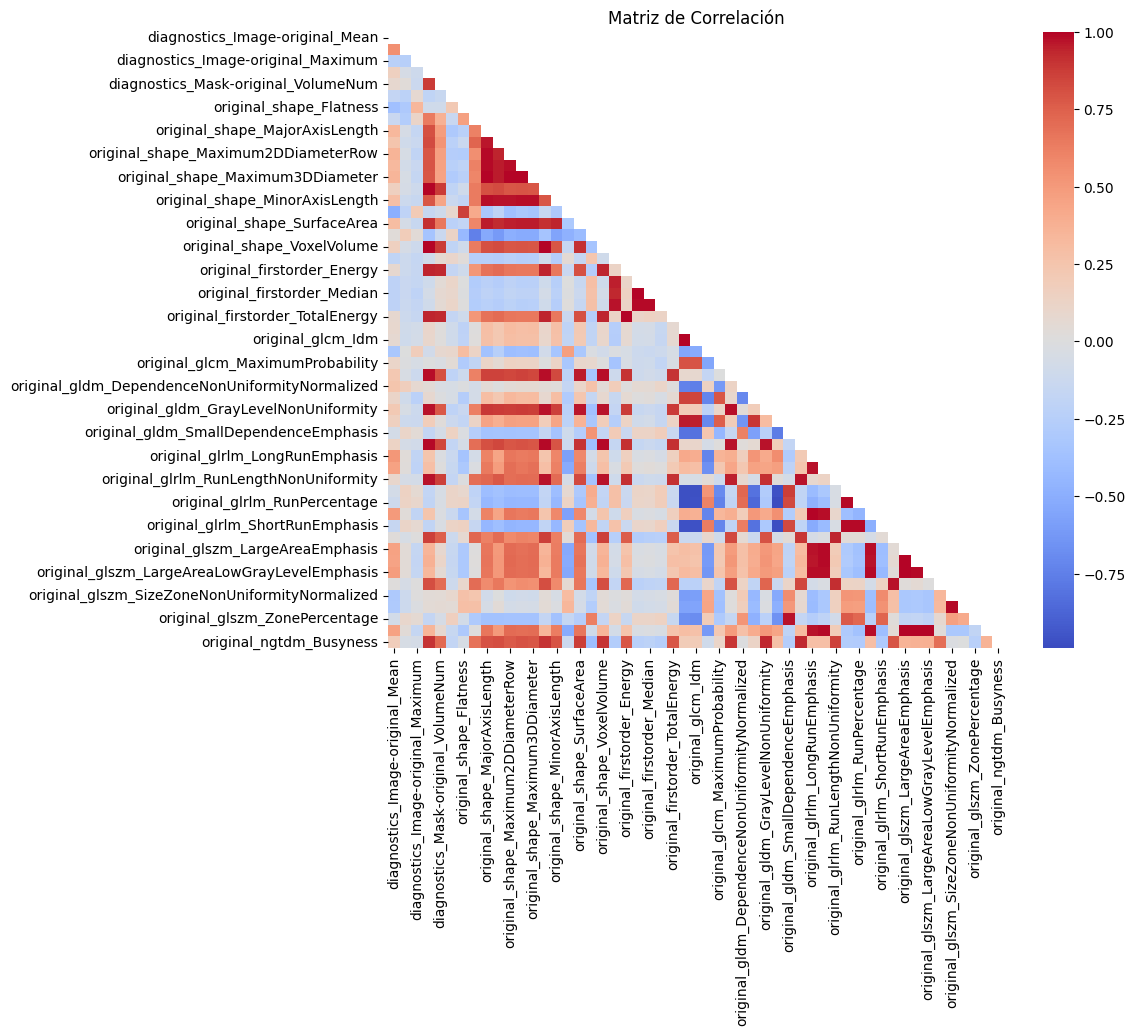

In [57]:
# CUIDADO: No se pintan todas las variables
plot_correlation_matrix(df_filt_reseg.drop(columns=['subject']))

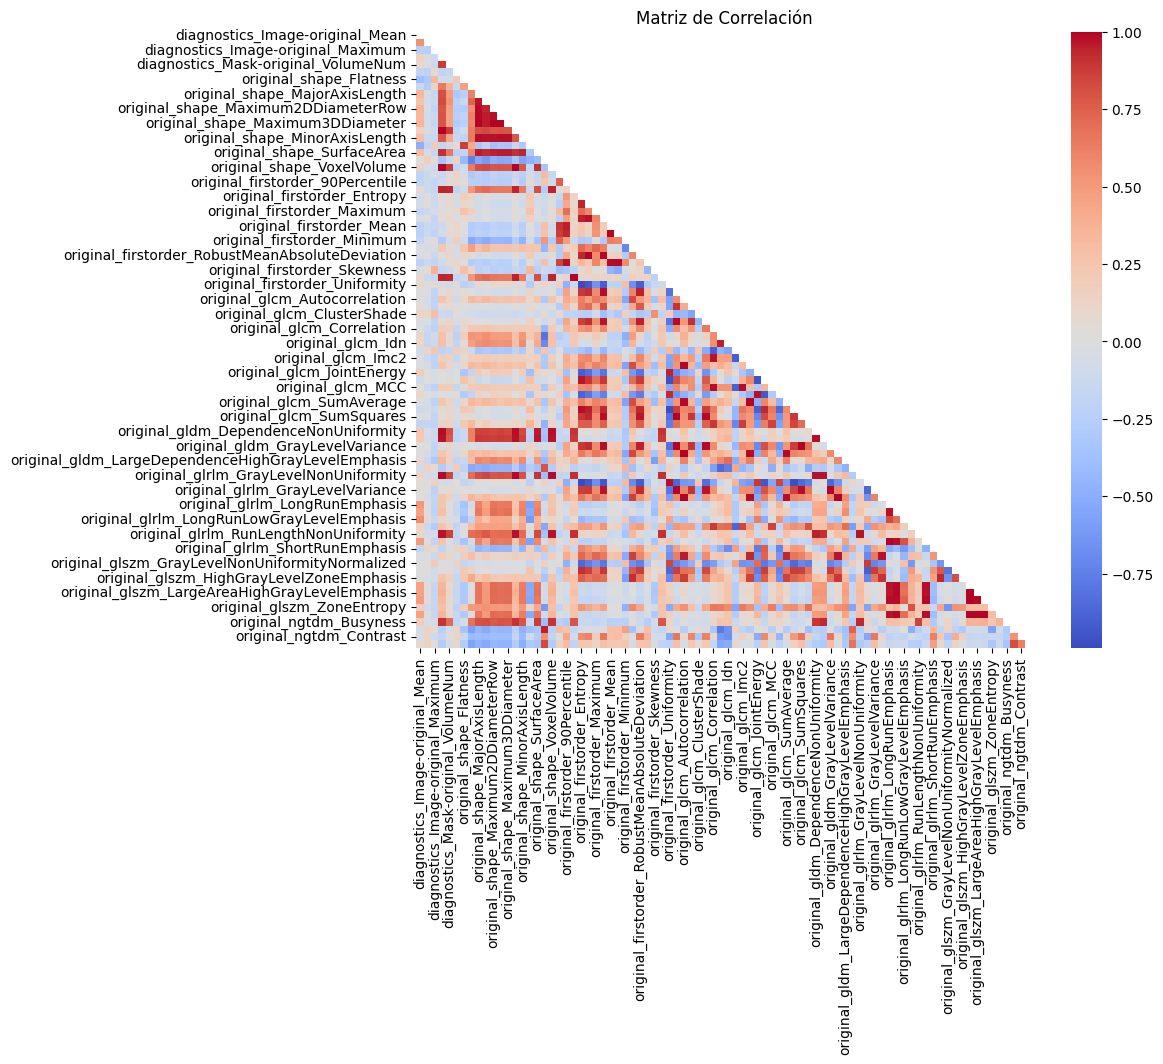

In [ ]:
# CUIDADO: No se pintan todas las variables
plot_correlation_matrix(df_filt_interp.drop(columns=['subject']))

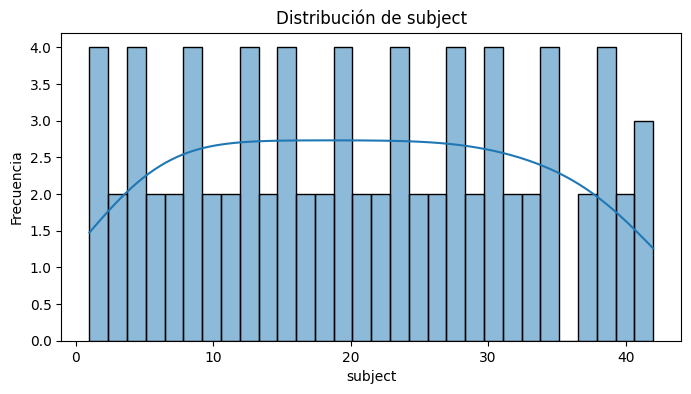

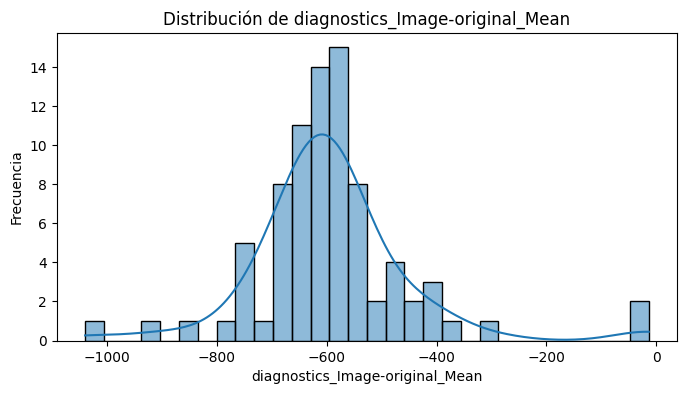

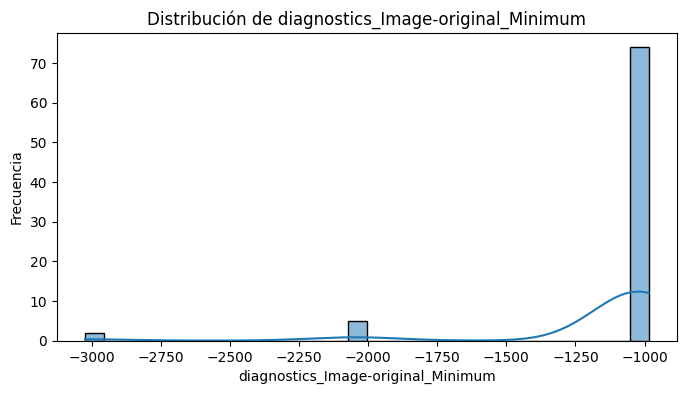

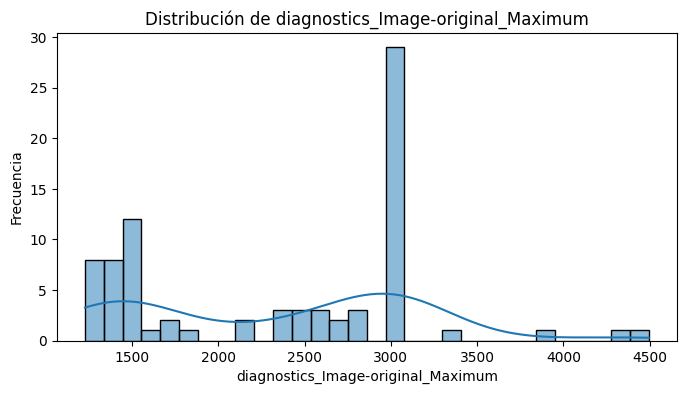

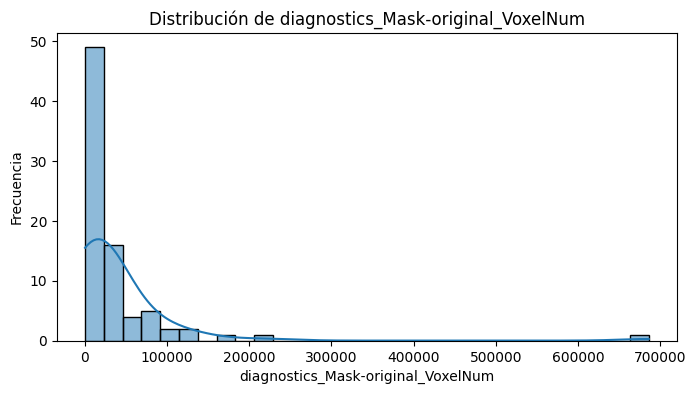

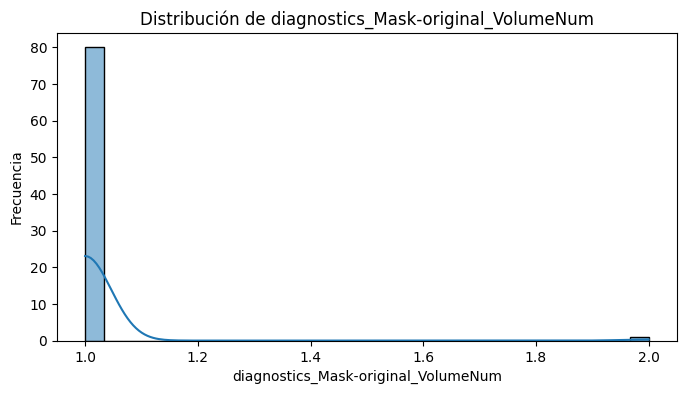

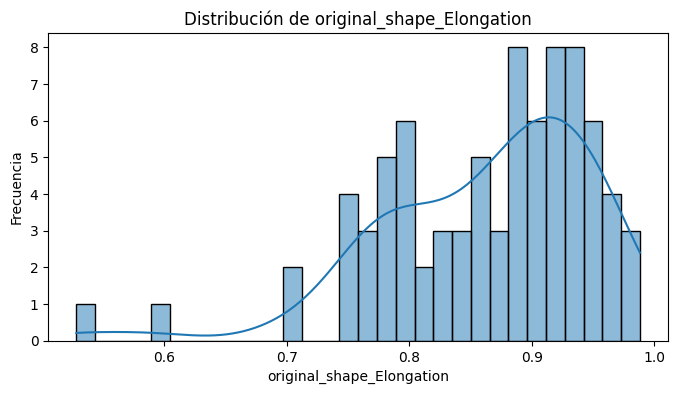

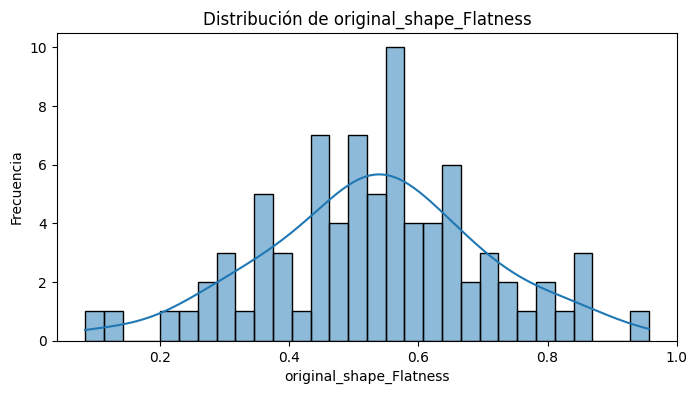

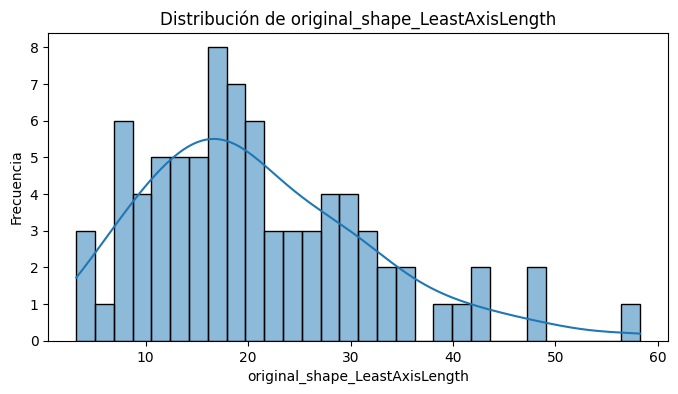

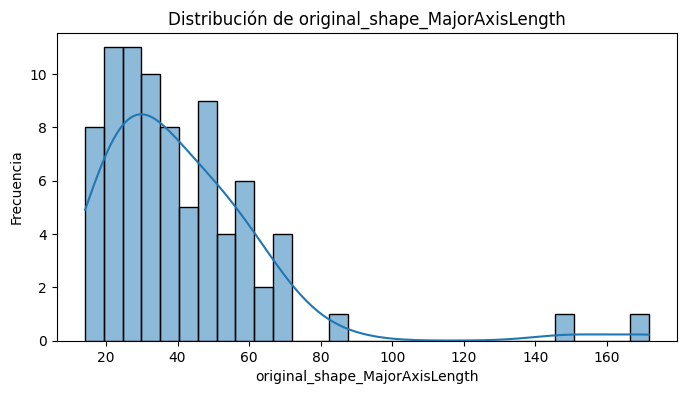

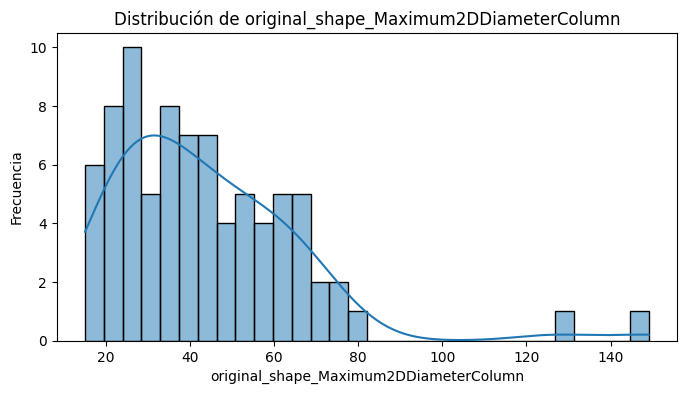

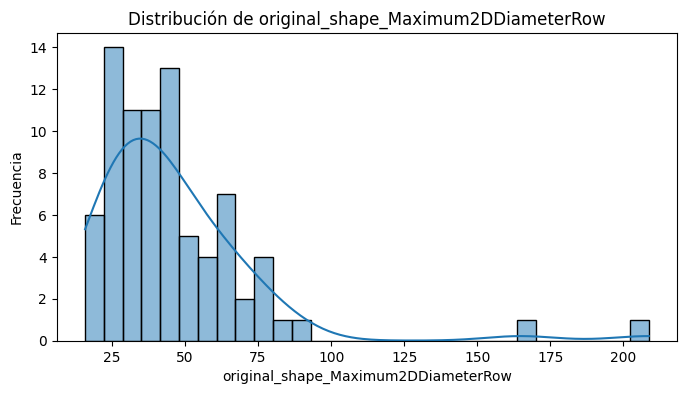

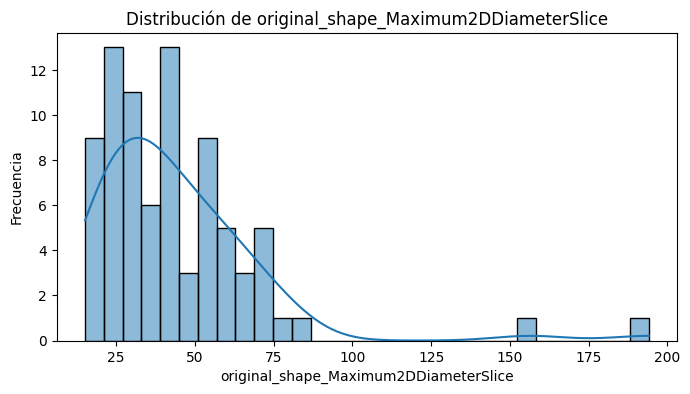

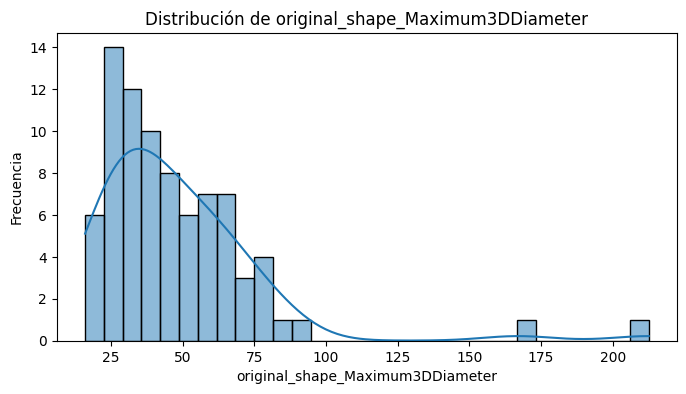

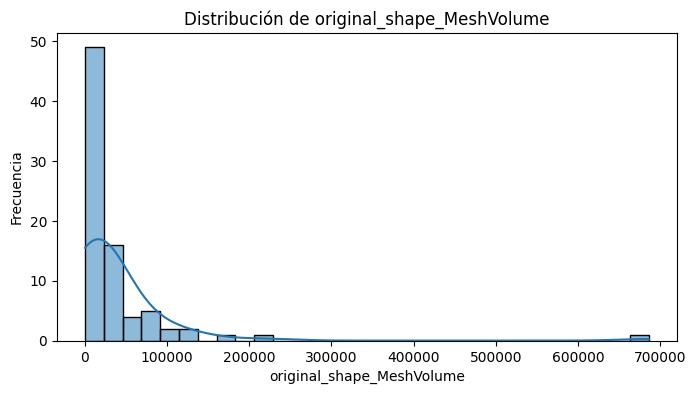

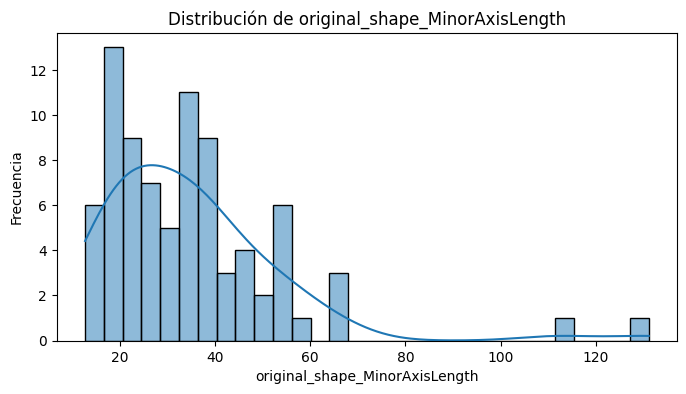

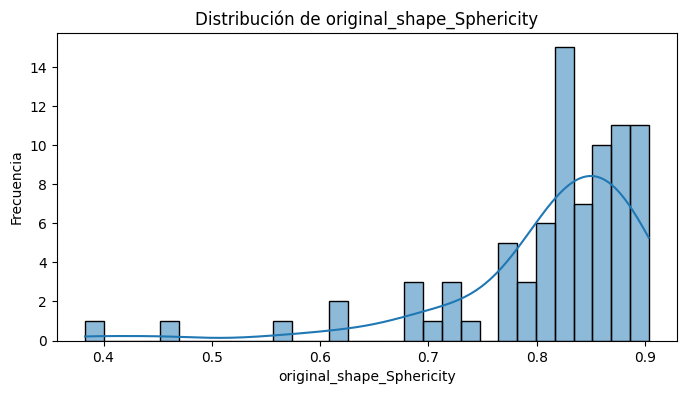

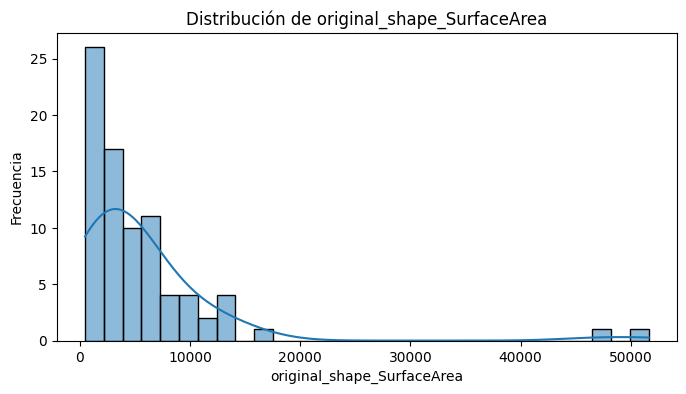

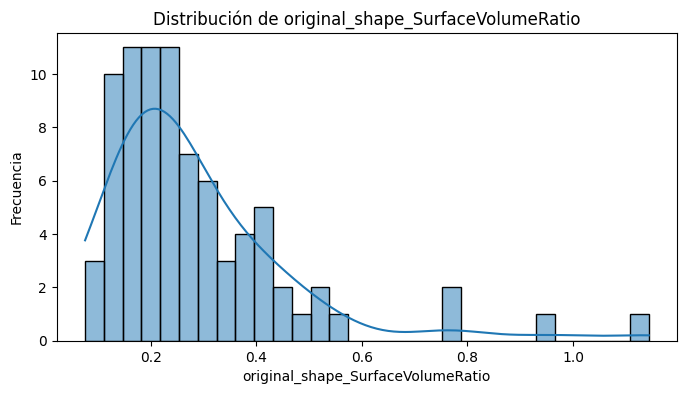

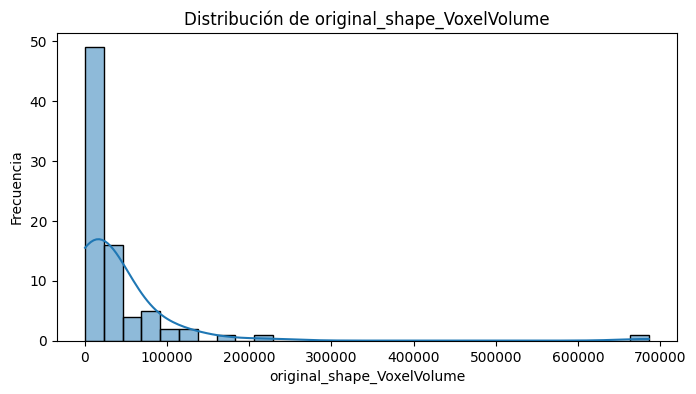

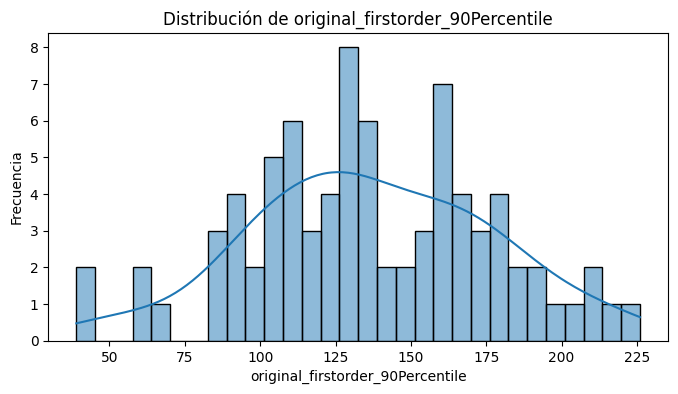

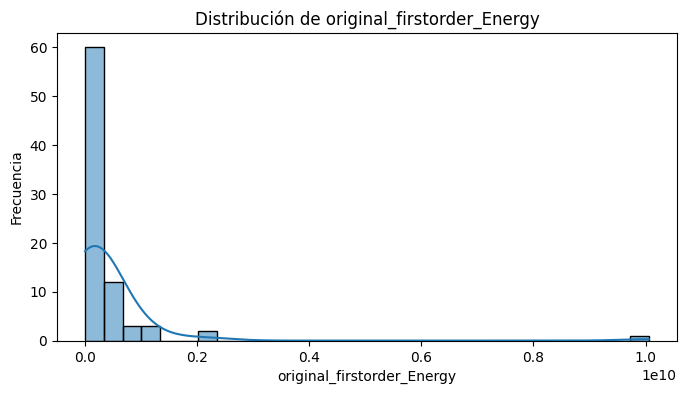

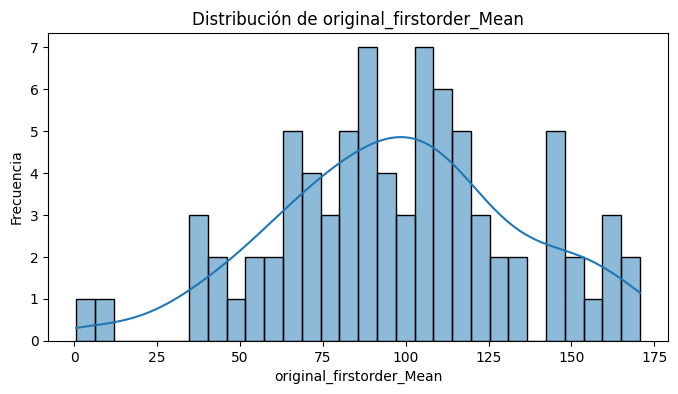

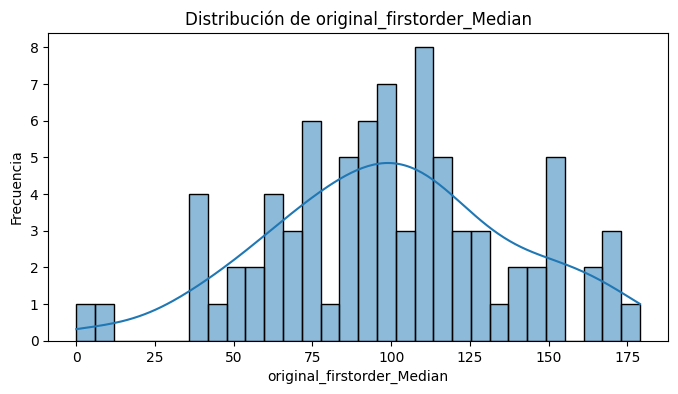

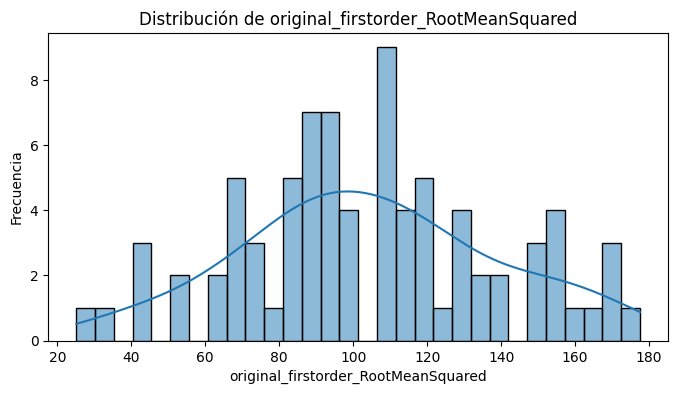

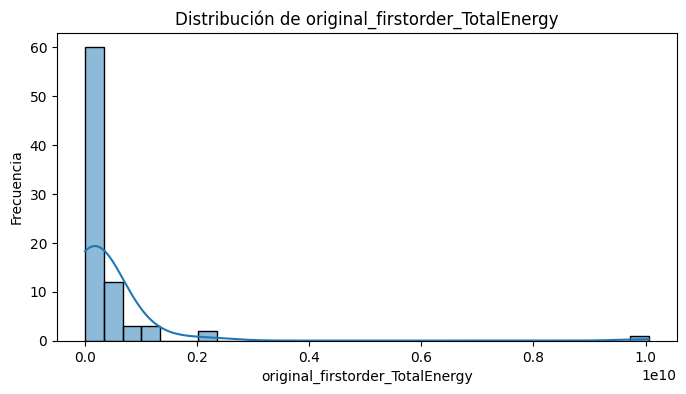

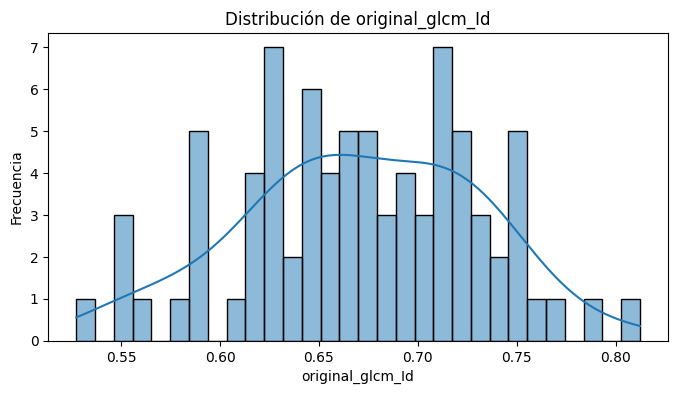

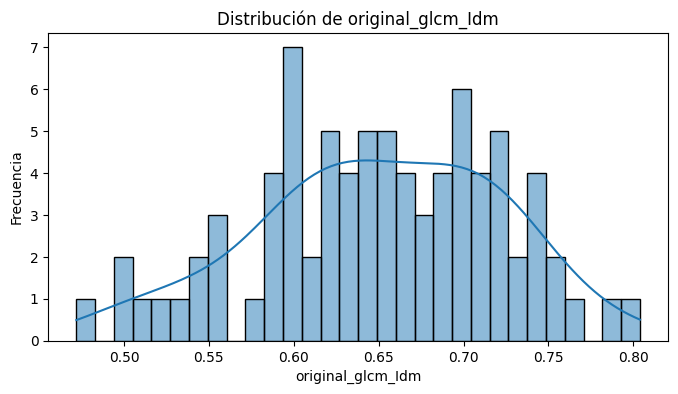

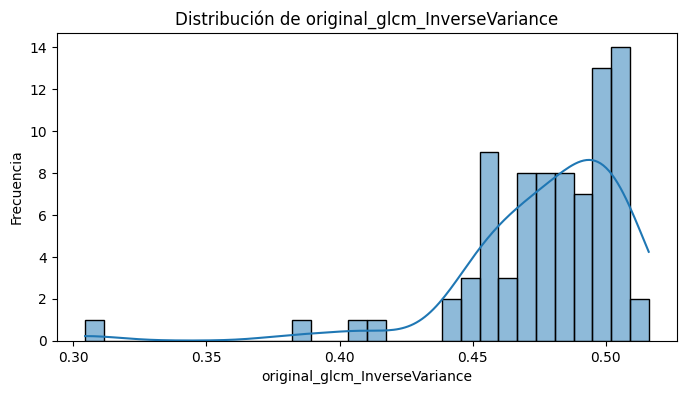

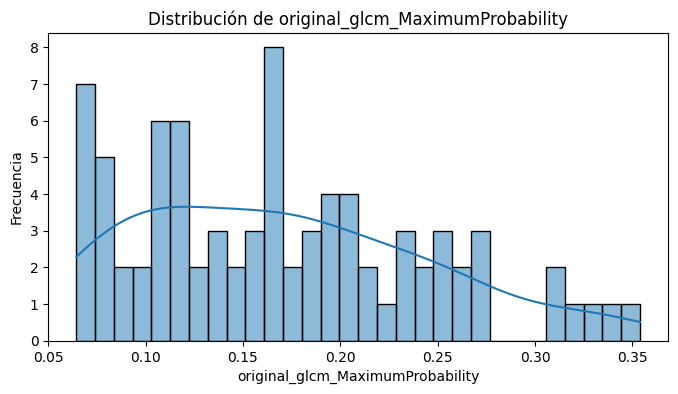

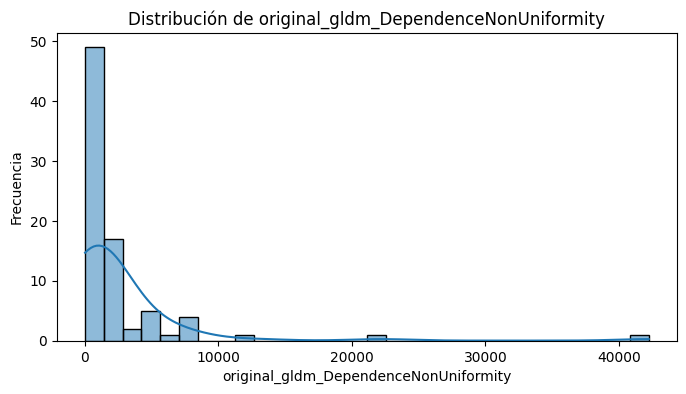

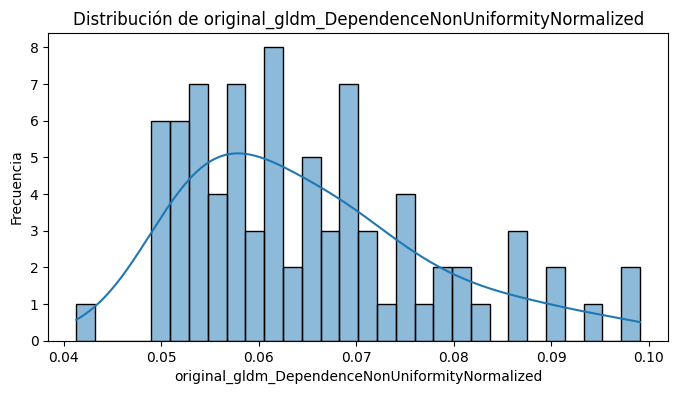

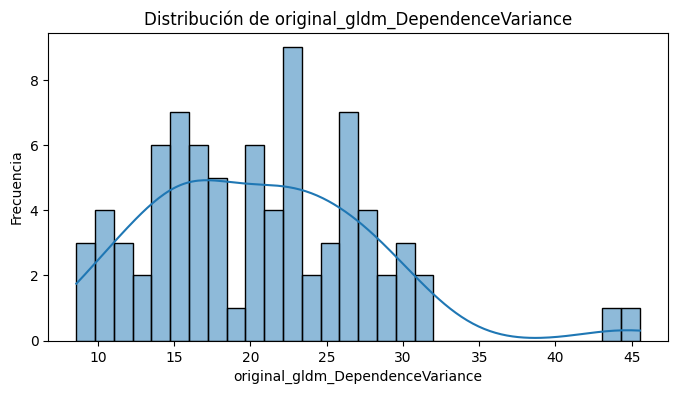

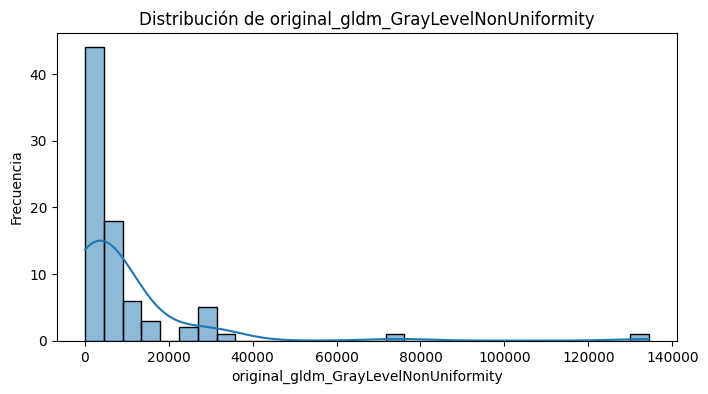

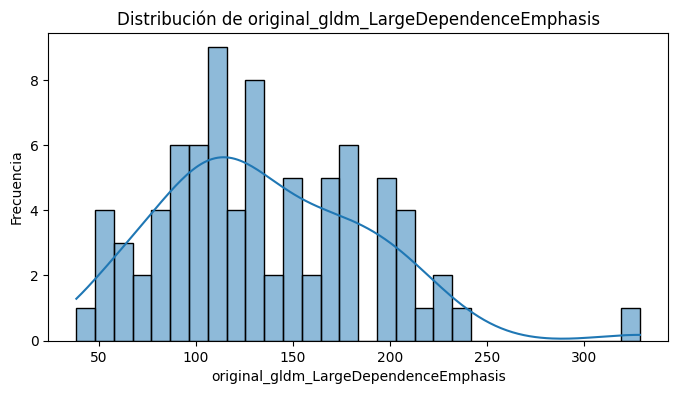

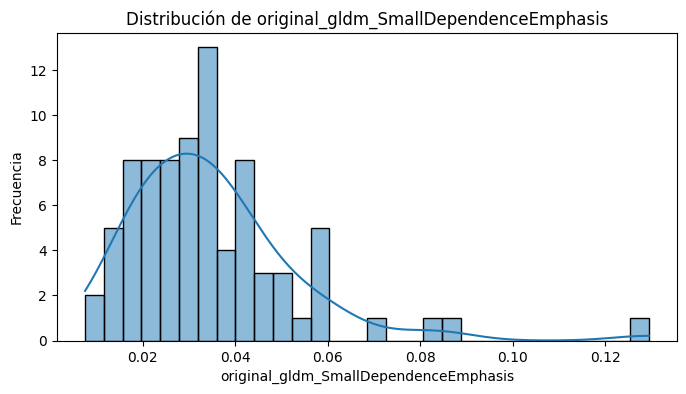

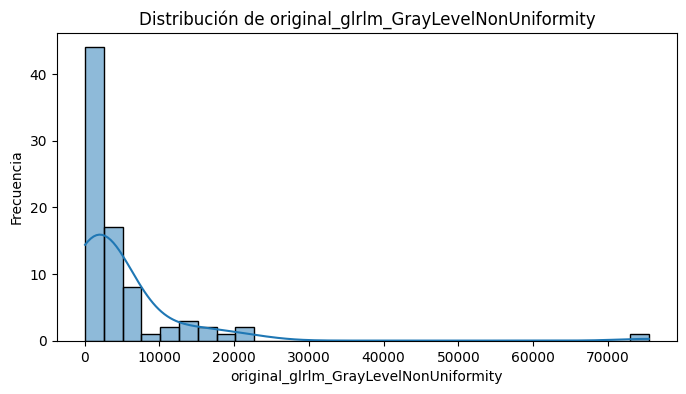

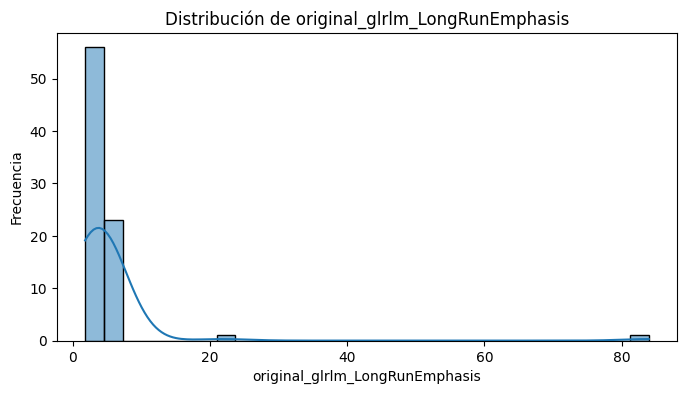

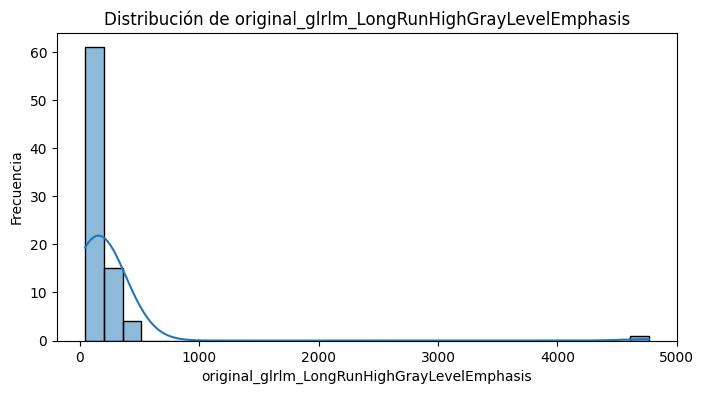

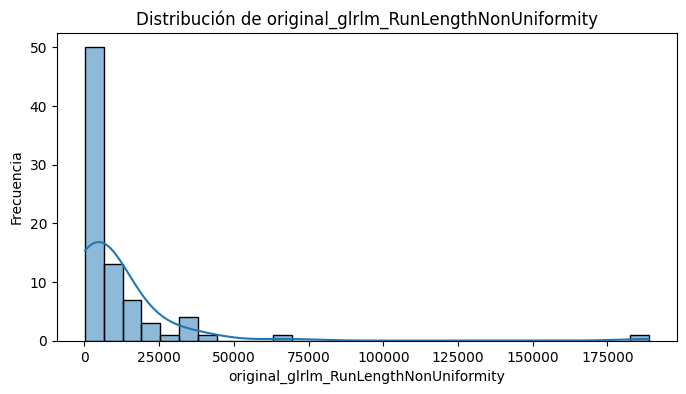

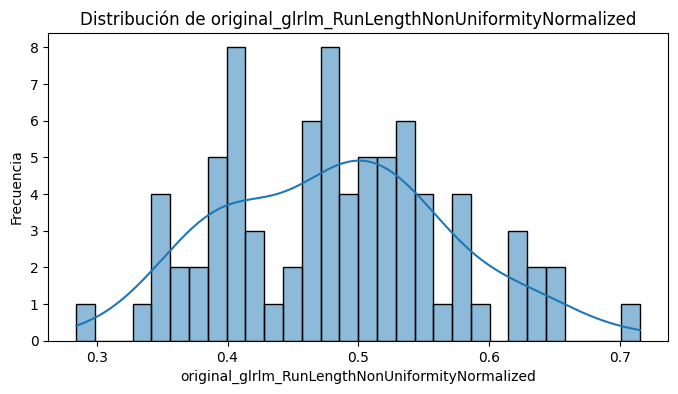

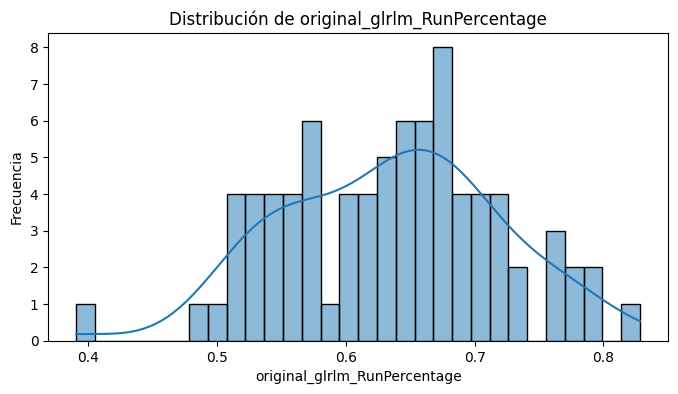

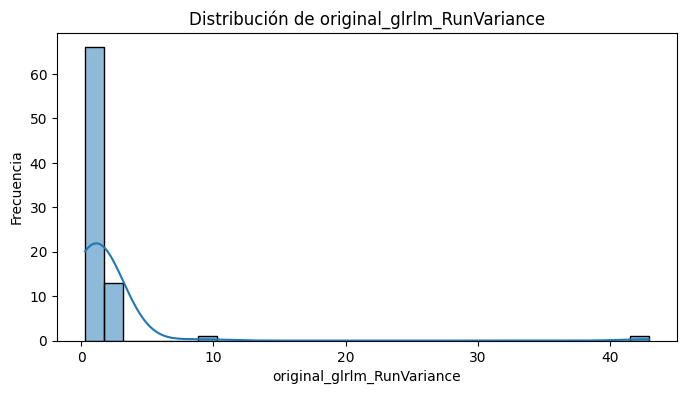

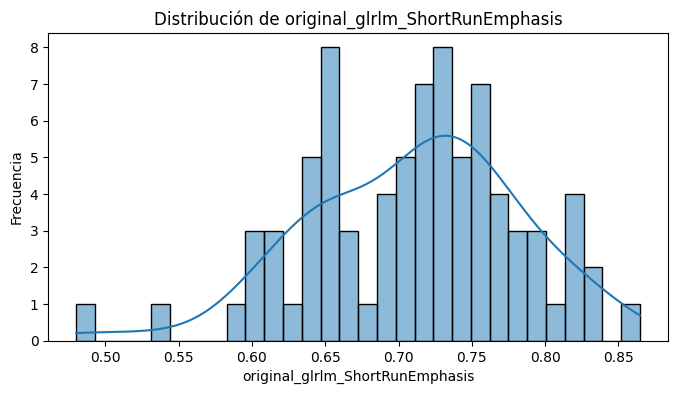

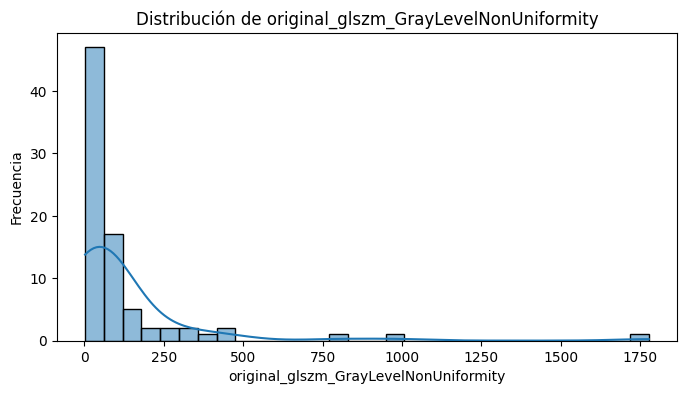

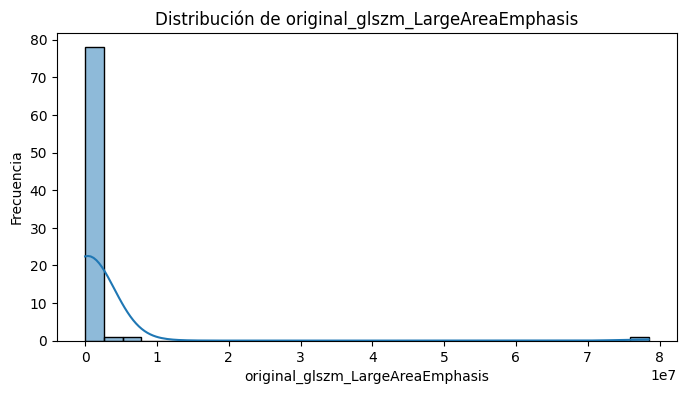

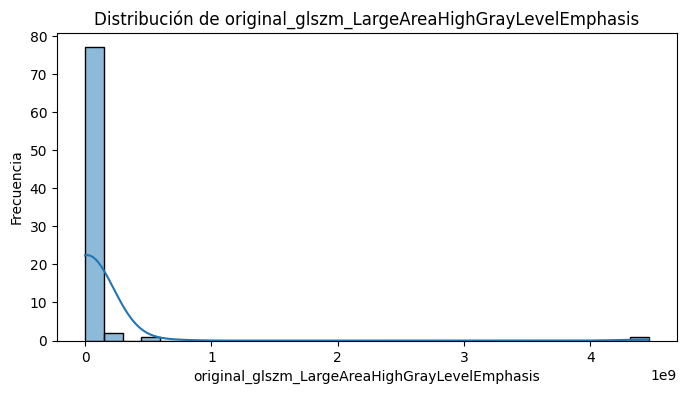

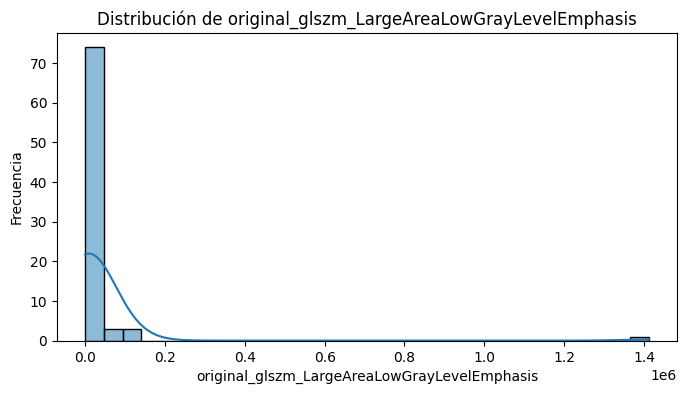

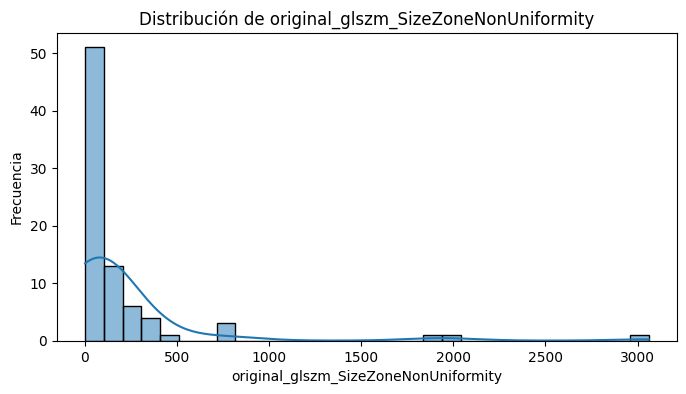

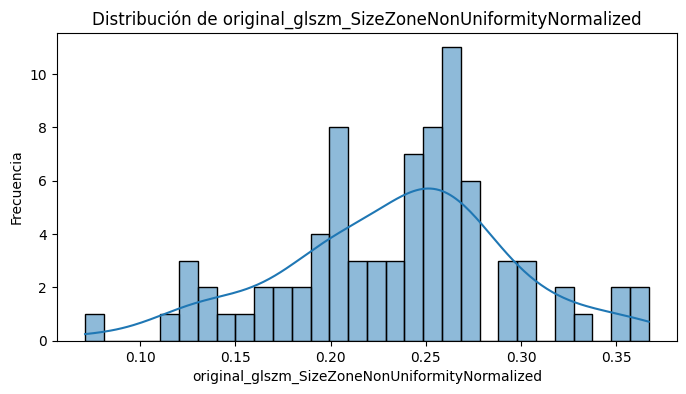

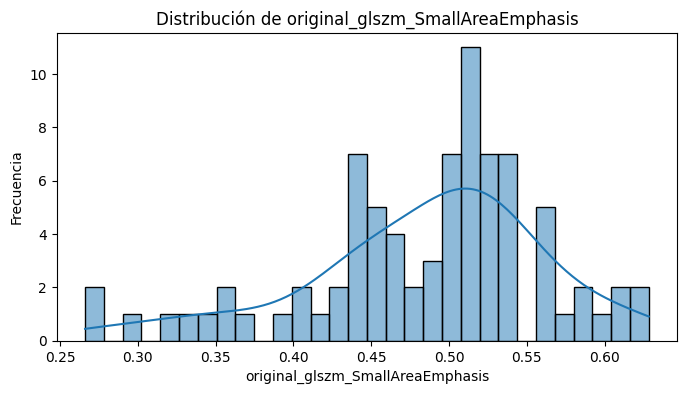

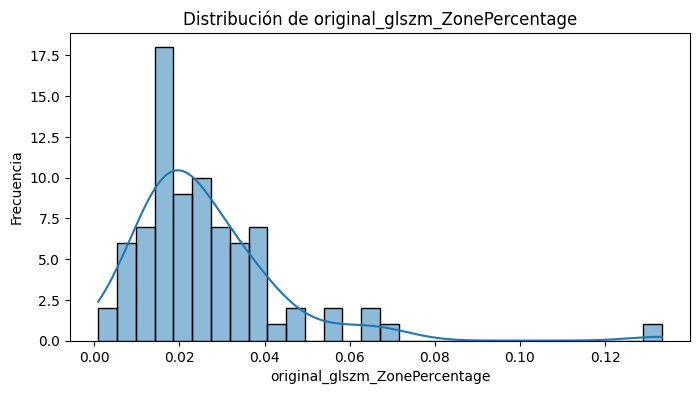

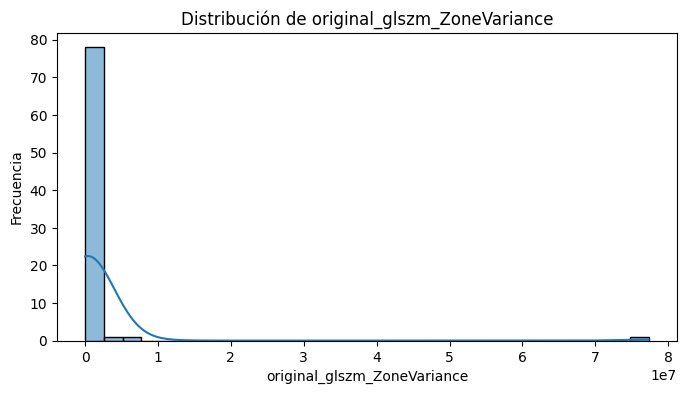

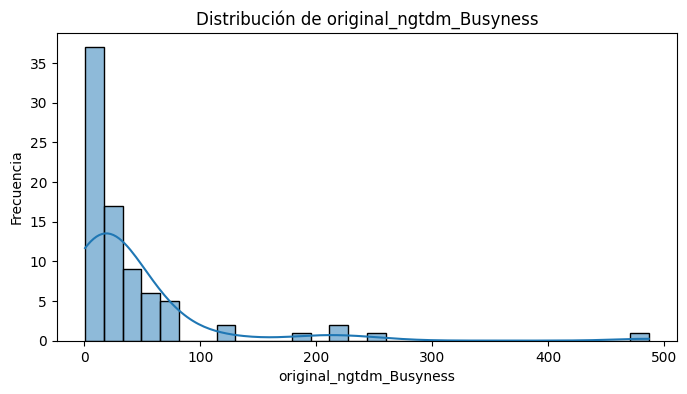

In [58]:
plot_variable_distribution(df_filt_reseg)

In [ ]:
plot_variable_distribution(df_filt_interp)

In [60]:
# Pre-process for ML Algorithms
X_reseg, y_reseg, removed_reseg = preprocess_features(df_filt_reseg, 'cancer')


ValueError: could not convert string to float: 'v3.0.1'

# ML Algorithms

In [ ]:

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)

In [ ]:
models = {
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=0),
            'params': {
                'max_depth': [5],
                'min_samples_split': [2]
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=0),
            'params': {
                'n_estimators': [100],
                'max_depth': [5]
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(random_state=0),
            'params': {
                'n_estimators': [100],
                'learning_rate': [0.1]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3],
                'weights': ['uniform']
            }
        }
    }

In [ ]:
# models = {
#         'DecisionTree': {
#             'model': DecisionTreeClassifier(random_state=0),
#             'params': {
#                 'max_depth': [None, 5, 10],
#                 'min_samples_split': [2, 5]
#             }
#         },
#         'RandomForest': {
#             'model': RandomForestClassifier(random_state=0),
#             'params': {
#                 'n_estimators': [100, 200],
#                 'max_depth': [None, 10]
#             }
#         },
#         'GradientBoosting': {
#             'model': GradientBoostingClassifier(random_state=0),
#             'params': {
#                 'n_estimators': [100, 200],
#                 'learning_rate': [0.01, 0.1]
#             }
#         },
#         'KNN': {
#             'model': KNeighborsClassifier(),
#             'params': {
#                 'n_neighbors': [3, 5, 7],
#                 'weights': ['uniform', 'distance']
#             }
#         }
#     }

In [ ]:
def plot_confusion_matrix(cm, model_name, params, output_path='images'):
    """
    Dibuja y guarda la matriz de confusión.
    """
    os.makedirs(output_path, exist_ok=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}\n{params}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fname = f"cm_{model_name}_{abs(hash(frozenset(params.items())))}.png"
    plt.savefig(os.path.join(output_path, fname))
    plt.show()
    plt.close()


def plot_roc_curve(y_test, y_prob, model_name, params, output_path='images'):
    """
    Dibuja y guarda la curva ROC.
    """
    os.makedirs(output_path, exist_ok=True)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}\n{params}')
    plt.legend(loc='lower right')
    fname = f"roc_{model_name}_{abs(hash(frozenset(params.items())))}.png"
    plt.savefig(os.path.join(output_path, fname))
    plt.show()
    plt.close()

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, params):
    """
    Calcula métricas, muestra el reporte y dibuja CM y ROC.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"==> {model_name} {params}")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name, params)
    plot_roc_curve(y_test, y_prob, model_name, params)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reseg, y_reseg, test_size=0.2, random_state=42, stratify=y_reseg)

for name, cfg in models.items():
    base = cfg['model']
    for params in ParameterGrid(cfg['params']):
        print(f"Training {name} with {params}")
        model = base.set_params(**params)
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, name, params)